### Ray Paths and TT Curves for the Moon

Written by *Nick Mancinelli*, July 2018

In [120]:
#Read in Alex's Weber model 
%matplotlib inline

import pandas as pd
names = ['Radius_meters','Density','Vp','Vs','Dummy','Dummy','Dummy','Dummy','Dummy']
df = pd.read_csv('weber_minos_nopml.txt', delim_whitespace = True, skiprows = 3, names = names)

#Adjust units
df['Radius_km'] = df['Radius_meters']/1000.
df['Vp'] = df['Vp']/1000.
df['Vs'] = df['Vs']/1000.
df['Density'] = df['Density']/1000.
radius_max = df.Radius_km.tolist()[-1]
df['Depth_km'] = radius_max - df['Radius_km']
df = df.iloc[::-1]

#Write in .nd format for taup calculation
fout = open('weber.nd','w')

for irow, row in df.iterrows():
    string = '%4.0f %5.1f %5.1f %5.1f\n' % (row.Depth_km, row.Vp, row.Vs, row.Density)
    fout.write(string)
    if irow < len(df.Depth_km.tolist()) and irow > 0:
        if df.loc[irow-1].Depth_km == row.Depth_km:
            if row.Depth_km > 30. and row.Depth_km < 45.:
                fout.write('mantle\n')
            elif row.Depth_km > 1400. and row.Depth_km < 1415.:
                fout.write('outer-core\n')
            elif row.Depth_km > 1490. and row.Depth_km < 1505.:
                fout.write('inner-core\n')
                
fout.close()

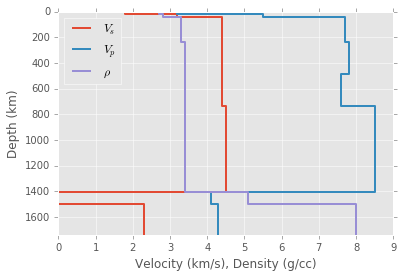

In [121]:
from matplotlib import pylab as plt

plt.figure()

lw = 2

plt.plot(df.Vs, df.Depth_km, label=r'$V_s$', lw = lw)
plt.plot(df.Vp, df.Depth_km, label=r'$V_p$', lw = lw)
plt.plot(df.Density, df.Depth_km, label=r'$\rho$', lw = lw)
_ = plt.ylim(max(df.Depth_km), min(df.Depth_km))
_ = plt.legend(loc='best')
_ = plt.ylabel('Depth (km)')
_ = plt.xlabel('Velocity (km/s), Density (g/cc)')

In [122]:
#Check nd file
!cat weber.nd

   0   3.2   1.8   2.7
  15   3.2   1.8   2.7
  15   5.5   3.2   2.8
  40   5.5   3.2   2.8
mantle
  40   7.7   4.4   3.3
 238   7.7   4.4   3.3
 238   7.8   4.4   3.4
 488   7.8   4.4   3.4
 488   7.6   4.4   3.4
 738   7.6   4.4   3.4
 738   8.5   4.5   3.4
1257   8.5   4.5   3.4
1257   8.5   4.5   3.4
1407   8.5   4.5   3.4
outer-core
1407   4.1   0.0   5.1
1437   4.1   0.0   5.1
1497   4.1   0.0   5.1
inner-core
1497   4.3   2.3   8.0
1729   4.3   2.3   8.0
1737   4.3   2.3   8.0


In [127]:
#Build taup model through obspy wrapper

import obspy
from obspy.taup import taup_create, TauPyModel
taup_create.build_taup_model('weber.nd')
model = TauPyModel(model="weber")

Building obspy.taup model for 'weber.nd' ...


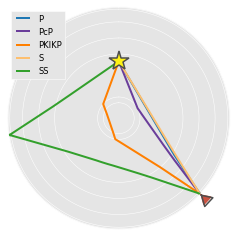

In [149]:
#Plot some ray paths

arrivals = model.get_ray_paths(source_depth_in_km=850, distance_in_degree=133, phase_list=["S","SS","P","PcP","PKIKP","PKIKP"])
ax = arrivals.plot_rays(legend=True)

#### Print travel times

for arrival in arrivals:
    print(arrival, arrival.time/60.)

There were 0 epicentral distances without an arrival


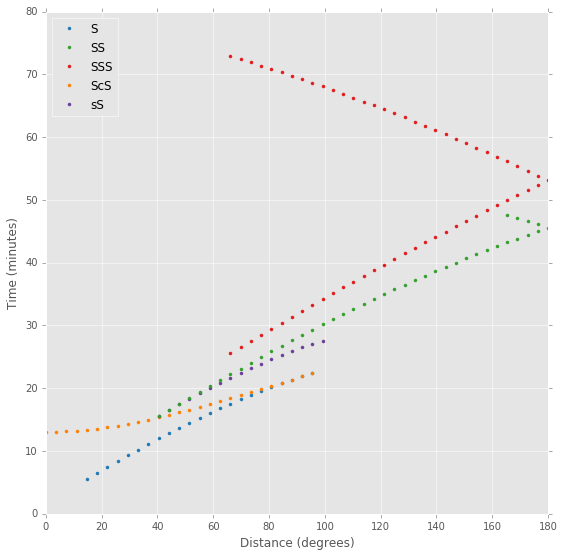

In [131]:
#Plot travel time curves

from obspy.taup import plot_travel_times

import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(9, 9))

ax = plot_travel_times(source_depth=750, phase_list=["sS", "S","ScS","SS","SSS"], ax=ax, fig=fig, verbose=True)

In [73]:
#distance depth #time

from numpy import nan

phase_list = ["P","S","PcP","ScS","PcS","ScP"]


string = '%8s %8s %7s %7s %7s %7s %7s %7s\n' % ('DelDeg','Depth_km','P',"S","PcP",'ScS','PcS','ScP')

fout = open('weber_tt.txt','w')

fout.write(string)

for distance in range(30,120):
    for depth in range(0,801,50):
        
        times = {}
        
        for phase in phase_list:
            times[phase] = nan
        
        try:
            arrivals = model.get_ray_paths(
                source_depth_in_km=depth, 
                distance_in_degree=distance, 
                phase_list=phase_list)
            
            for phase in phase_list:
                for arrival in arrivals:
                    if arrival.name == phase:
                        times[phase] = arrival.time 
                        
        except:
            pass
            
        
        if len(arrivals) > 0:
        
            string = '%8d %8d %7.2f %7.2f %7.2f %7.2f %7.2f %7.2f\n' % (distance, depth, times['P'], times['S'], times['PcP'], times['ScS'], times["PcS"], times["ScP"] )
        
            fout.write(string)
            
fout.close()
    

In [8]:
!cat weber_tt.txt

  DelDeg Depth_km       P       S     PcP     ScS     PcS     ScP
      30        0  129.31  226.17  365.38  680.95  522.56  522.56
      30       50  121.38  212.36  354.85  662.55  512.04  504.15
      30      100  120.01  209.96  348.37  651.21  505.57  492.80
      30      150  119.01  208.22  341.89  639.88  499.10  481.45
      30      200  119.00  207.14  335.41  628.55  492.63  470.10
      30      250  117.75  206.73  328.95  617.22  486.19  458.75
      30      300     nan     nan  322.56  605.90  479.81  447.40
      30      350     nan     nan  316.17  594.57  473.43  436.06
      30      400     nan     nan  309.78  583.25  467.05  424.71
      30      450     nan     nan  303.39  571.94  460.68  413.37
      30      500     nan     nan  296.96  560.63  454.27  402.03
      30      550     nan     nan  290.41  549.32  447.73  390.69
      30      600     nan     nan  283.85  543.46  444.08  382.23
      30      650     nan     nan     nan     nan     nan     nan
      30  

In [147]:
for arrival in arrivals:
    print(arrival.name, arrival.time)

P 299.581544401
PcP 301.263581526
PKiKP 337.905621692
PKIKP 419.617103318
S 551.184322433
SS 1189.71705022


In [134]:
#Lunar Geometrical Spreading
#
from numpy import arcsin

def get_energy_density(psph, dpsph_ddeldeg, theta1, theta2, deldeg):
    from numpy import cos, sin, pi
    num = psph * abs(dpsph_ddeldeg)
    delrad = deldeg * pi/180.
    den = cos(theta1) * cos(theta2) * sin(delrad)
    return num / den
    

for d0 in range(16,156,10):
    ddeldeg = 0.05
    print('Delta = %d degrees' % d0)
    print('   %5s %7s %7s' % ('Name', 'Time', 'Amp.'))

    source_depth = 850

    arrivals0    = model.get_ray_paths(source_depth_in_km=source_depth, distance_in_degree=d0, phase_list=["S","SS","SSS"])
    arrivals_ptb = model.get_ray_paths(source_depth_in_km=source_depth, distance_in_degree=d0+ddeldeg, phase_list=["S","SS","SSS"])

    for ii in range(len(arrivals0)):
        psph = arrivals0[ii].ray_param
        dpsph = arrivals_ptb[ii].ray_param - arrivals0[ii].ray_param
        dpsph_ddeldeg = dpsph/ddeldeg
        v1=4.5
        v2=0.5
        r1=1737.-source_depth
        r2=1737.
        theta1 = arcsin(psph*v1/r1)
        theta2 = arcsin(psph*v2/r2)

        energy_density = get_energy_density(psph, dpsph_ddeldeg, theta1, theta2, d0)
        
        string = '   %5s %7.2f %7.2f' % (arrivals0[ii].name, arrivals0[ii].time, energy_density**0.5)
        print(string)
    

Delta = 16 degrees
    Name    Time    Amp.
     SSS 1875.57   28.59
     SSS 1964.20   24.85
Delta = 26 degrees
    Name    Time    Amp.
     SSS 1845.32   23.80
     SSS 1989.14   18.89
Delta = 36 degrees
    Name    Time    Amp.
     SSS 1813.99   21.71
     SSS 2012.69   15.62
Delta = 46 degrees
    Name    Time    Amp.
     SSS 1781.65   20.93
     SSS 2034.81   13.51
Delta = 56 degrees
    Name    Time    Amp.
      SS 1351.10   11.09
     SSS 1748.44   21.21
     SSS 2055.47   12.03
Delta = 66 degrees
    Name    Time    Amp.
       S  367.58   25.81
      SS 1337.10   11.51
     SSS 1714.51   22.95
     SSS 2074.63   10.92
Delta = 76 degrees
    Name    Time    Amp.
       S  401.12   23.60
      SS 1320.91   12.03
     SSS 2092.27   10.07
Delta = 86 degrees
    Name    Time    Amp.
       S  433.23   21.99
      SS 1302.58   12.69
     SSS 2108.37    9.39
Delta = 96 degrees
    Name    Time    Amp.
       S  463.36   20.76
      SS 1282.16   13.52
     SSS 2122.90    8.86
Delt